In [1]:
import os
import glob
import sys
import dotenv

from eolearn.core import (
    FeatureType,
    MergeEOPatchesTask,
    EONode,
    linearly_connect_tasks,
    EOWorkflow,
    OutputTask,
    LoadTask,
    SaveTask,
    OverwritePermission,
    EOExecutor,
)
from eolearn.core.eoworkflow_tasks import InputTask
import datetime

import matplotlib.pyplot as plt
%matplotlib inline

root_dir = os.path.abspath('../')
if not root_dir in sys.path: sys.path.append(root_dir)

import eolearn_extras as eolx
from sdb_utils.acolite import ReadAcoliteProduct
from sdb_utils.acolite import enrich_acolite_path_with_datetime_information
from sdb_utils.paths import return_product_paths_for_dt

dotenv.load_dotenv()
data_root_path = os.environ.get('data_root')

In [2]:
sentinel_archives_root = os.path.abspath(os.path.join(data_root_path, 'sentinel_bahamas'))
sentinel_archives_pattern = f'{sentinel_archives_root}/*.SAFE'
sentinel_archives = glob.glob(sentinel_archives_pattern)

l1c_products = eolx.io.get_products_by_level(sentinel_archives, 'L1C')
l2a_products = eolx.io.get_products_by_level(sentinel_archives, 'L2A')

sentinel_acolite_folder_pattern = f'{sentinel_archives_root}/*ACOLITE*'
sentinel_acolite_folders = glob.glob(sentinel_acolite_folder_pattern)
sentinel_acolite_products = [enrich_acolite_path_with_datetime_information(path) for path in sentinel_acolite_folders]

In [3]:
observation_dt_of_interest = datetime.datetime(2021, 10, 19, 15, 55, 31)
l1c_path, l2a_path, acolite_path = return_product_paths_for_dt(
    l1c_products=l1c_products,
    l2a_products=l2a_products,
    acolite_products=sentinel_acolite_products,
    dt=observation_dt_of_interest,
)

l1c_path, l2a_path, acolite_path

('D:\\sdb_datasets\\sentinel_bahamas\\S2A_MSIL1C_20211019T155531_N0301_R011_T17RQJ_20211019T192647.SAFE',
 'D:\\sdb_datasets\\sentinel_bahamas\\S2A_MSIL2A_20211019T155531_N9999_R011_T17RQJ_20220423T204757.SAFE',
 'D:\\sdb_datasets\\sentinel_bahamas\\S2A_MSI_20211019T155531_ACOLITE_SUBSET')

In [4]:
bathy_eop_path = os.path.abspath(
    os.path.join(data_root_path, 'eopatches', 'bahamas_bathy_eop')
)
load_bathy_eop = LoadTask(bathy_eop_path)

output_label = 'bahamas_bathy_eop'

wf_nodes = linearly_connect_tasks(
    load_bathy_eop,
    OutputTask(output_label),
)
workflow = EOWorkflow(wf_nodes)

workflow_result = workflow.execute()
bahamas_bathy_eop = workflow_result.outputs[output_label]

input_bathy_task = InputTask(bahamas_bathy_eop)
input_bathy_node = EONode(input_bathy_task, inputs=tuple())

height, width, _ = bahamas_bathy_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')].shape

read_l1c_eop_task = eolx.io.ReadSentinelArchiveTask(
    target_shape=(height, width),
    bbox=bahamas_bathy_eop.bbox
)
read_l1c_node = EONode(read_l1c_eop_task, inputs=tuple())

read_l2a_eop_task = eolx.io.ReadSentinelArchiveTask(
    target_shape=(height, width),
    bbox=bahamas_bathy_eop.bbox,
    digital_number_to_reflectance=True,
)
read_l2a_node = EONode(read_l2a_eop_task, inputs=tuple())

acolite_product = 'L2W'
reflectance_type = 'rhow'
acolite_data_feature = (FeatureType.DATA, f'{acolite_product}_data')
read_acolite_product_task = ReadAcoliteProduct(
    reference_bbox=bahamas_bathy_eop.bbox,
    feature=acolite_data_feature,
    acolite_product=acolite_product,
    reflectance_type=reflectance_type
)
read_acolite_node = EONode(read_acolite_product_task, inputs=tuple())

merge_patches_task = MergeEOPatchesTask()
merge_eop_node = EONode(
    merge_patches_task,
    inputs=[input_bathy_node, read_l1c_node, read_l2a_node, read_acolite_node]
)

output_label = 'merged_output'
output_task = OutputTask(output_label)
output_node = EONode(output_task, inputs=[merge_eop_node])

output_path = os.path.abspath(
    os.path.join(data_root_path, 'eopatches', 'bahamas_sentinel_merged')
)
save_eop_task = SaveTask(
    output_path,
    overwrite_permission=OverwritePermission.OVERWRITE_PATCH
)
save_eop_node = EONode(save_eop_task, inputs=[merge_eop_node])

read_merge_wf = EOWorkflow(
    [
        input_bathy_node,
        read_l1c_node,
        read_l2a_node,
        read_acolite_node,
        merge_eop_node,
        output_node,
        save_eop_node,
    ]
)

execution_args = {
    read_l1c_node: {'sentinel_archive_path': l1c_path},
    read_l2a_node: {'sentinel_archive_path': l2a_path},
    read_acolite_node: {'acolite_product_folder': acolite_path},
}

executor = EOExecutor(read_merge_wf, [execution_args], save_logs=True, logs_folder='../executor_logs')
read_merge_wf_res = executor.run(workers=4)

100%|██████████| 1/1 [00:15<00:00, 15.58s/it]


In [5]:
bahamas_merged_eop = read_merge_wf_res[0].outputs[output_label]
bahamas_merged_eop

EOPatch(
  data={
    L1C_data: numpy.ndarray(shape=(1, 894, 1946, 13), dtype=uint16)
    L2A_data: numpy.ndarray(shape=(1, 894, 1946, 12), dtype=float32)
    L2W_data: numpy.ndarray(shape=(1, 894, 1946, 11), dtype=float32)
  }
  data_timeless={
    bathy_data: numpy.ndarray(shape=(894, 1946, 1), dtype=float64)
  }
  mask_timeless={
    bathy_data_mask: numpy.ndarray(shape=(894, 1946, 1), dtype=uint8)
  }
  meta_info={
    acolite_overcorrection_info: <class 'dict'>, length=11
    mission: 'S2A'
  }
  bbox=BBox(((758523.8845987623, 2793786.7214435483), (777983.8845987623, 2802726.7214435483)), crs=CRS('32617'))
  timestamp=[datetime.datetime(2021, 10, 19, 15, 55, 31), datetime.datetime(2021, 10, 19, 15, 56, 16)]
)

In [6]:
bahamas_merged_eop.meta_info['acolite_overcorrection_info']

{'L2W_data_rhow_443': 0,
 'L2W_data_rhow_492': 0,
 'L2W_data_rhow_560': 0,
 'L2W_data_rhow_665': 0,
 'L2W_data_rhow_704': 0,
 'L2W_data_rhow_740': 0,
 'L2W_data_rhow_783': 0,
 'L2W_data_rhow_833': 0,
 'L2W_data_rhow_865': 0,
 'L2W_data_rhow_1614': 0,
 'L2W_data_rhow_2202': 0}

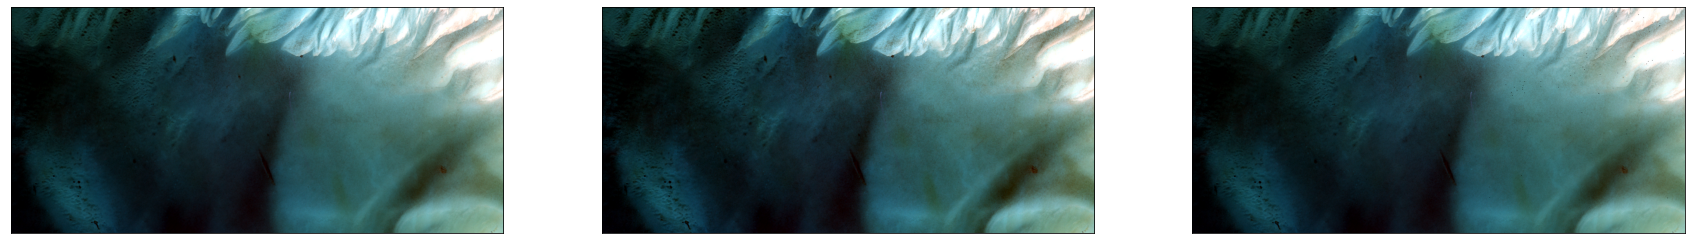

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(30, 40))

eolx.visualization.plot_eopatch(
    bahamas_merged_eop,
    rgb_bands=eolx.visualization.sentinel_2_true_color,
    feature=(FeatureType.DATA, "L1C_data"),
    stretch=True,
    ax=ax1,
)

eolx.visualization.plot_eopatch(
    bahamas_merged_eop,
    rgb_bands=eolx.visualization.sentinel_2_true_color,
    feature=(FeatureType.DATA, "L2A_data"),
    stretch=True,
    ax=ax2,
)

eolx.visualization.plot_eopatch(
    bahamas_merged_eop,
    rgb_bands=eolx.visualization.sentinel_2_true_color,
    feature=(FeatureType.DATA, "L2W_data"),
    stretch=True,
    ax=ax3,
)

plt.show()

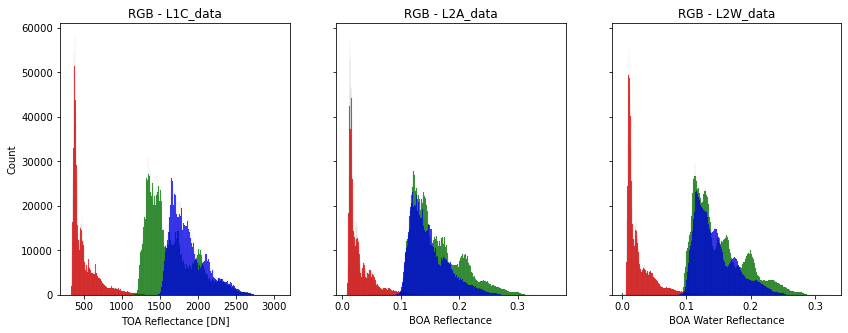

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(14, 5), sharey=True)

eolx.visualization.plot_band_histogram_rgb(
    bahamas_merged_eop, (FeatureType.DATA, "L1C_data"), ax=ax1, xlabel='TOA Reflectance [DN]'
)
eolx.visualization.plot_band_histogram_rgb(
    bahamas_merged_eop, (FeatureType.DATA, "L2A_data"), ax=ax2, xlabel='BOA Reflectance'
)
eolx.visualization.plot_band_histogram_rgb(
    bahamas_merged_eop, (FeatureType.DATA, "L2W_data"), ax=ax3, xlabel='BOA Water Reflectance'
)

plt.show()